<a href="https://www.kaggle.com/code/yasinsoylu123/tesla-stokprice-statsmodels-lstm?scriptVersionId=97855728" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv(r'../input/tesla-inc-tsla-dataset/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
1,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
3,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500
4,2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843 entries, 0 to 2842
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2843 non-null   object 
 1   Open       2843 non-null   float64
 2   High       2843 non-null   float64
 3   Low        2843 non-null   float64
 4   Close      2843 non-null   float64
 5   Adj Close  2843 non-null   float64
 6   Volume     2843 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.6+ KB


In [4]:
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
1,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
3,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500
4,2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000
5,2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000
6,2010-07-12,3.590,3.614,3.400,3.410,3.410,11012500
7,2010-07-13,3.478,3.728,3.380,3.628,3.628,13400500
8,2010-07-14,3.588,4.030,3.552,3.968,3.968,20976000
9,2010-07-15,3.988,4.300,3.800,3.978,3.978,18699000


In [5]:
df["Date"]=pd.to_datetime(df.Date,dayfirst=True)
df.set_index("Date",inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
2010-07-07,3.280000,3.326000,2.996000,3.160000,3.160000,34608500
2010-07-08,3.228000,3.504000,3.114000,3.492000,3.492000,38557000
...,...,...,...,...,...,...
2021-10-08,796.210022,796.380005,780.909973,785.489990,785.489990,16711100
2021-10-11,787.650024,801.239990,785.500000,791.940002,791.940002,14200300
2021-10-12,800.929993,812.320007,796.570007,805.719971,805.719971,22020000


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2843.000000,2843.000000,2843.000000,2843.000000,2843.000000,2.843000e+03
mean,105.868475,108.031370,103.555733,105.924597,105.924597,3.141524e+07
std,188.738974,192.483055,184.638617,188.836358,188.836358,2.841880e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,10.698000,11.026000,10.420000,10.727000,10.727000,1.251050e+07
50%,45.874001,46.493999,45.102001,45.916000,45.916000,2.481500e+07
75%,65.021000,66.251999,64.015001,65.275002,65.275002,4.012025e+07
max,891.380005,900.400024,871.599976,883.090027,883.090027,3.046940e+08


In [7]:
df=df.asfreq("d")

In [8]:
df.head(20)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0
2010-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000.0
2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000.0


In [9]:
df.isnull().sum()

Open         1281
High         1281
Low          1281
Close        1281
Adj Close    1281
Volume       1281
dtype: int64

In [10]:
df=df.fillna(method="bfill")

Text(0, 0.5, 'open price')

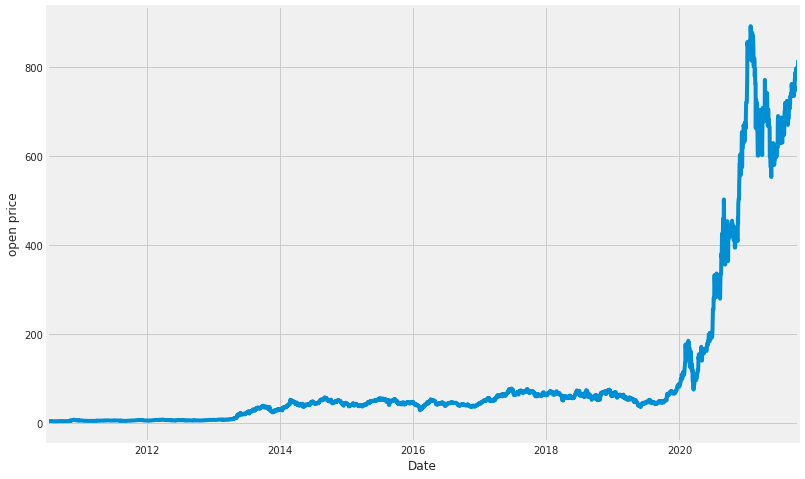

In [11]:
df['Open'].plot(figsize=(12,8))
plt.ylabel("open price")

Text(0, 0.5, 'Volume price')

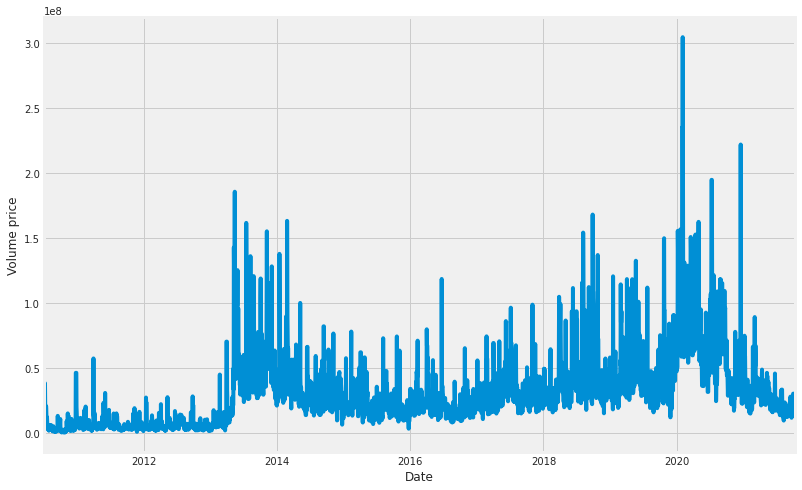

In [12]:
df['Volume'].plot(figsize=(12,8))
plt.ylabel("Volume price")

In [13]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
df['Total Pos'] = df.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

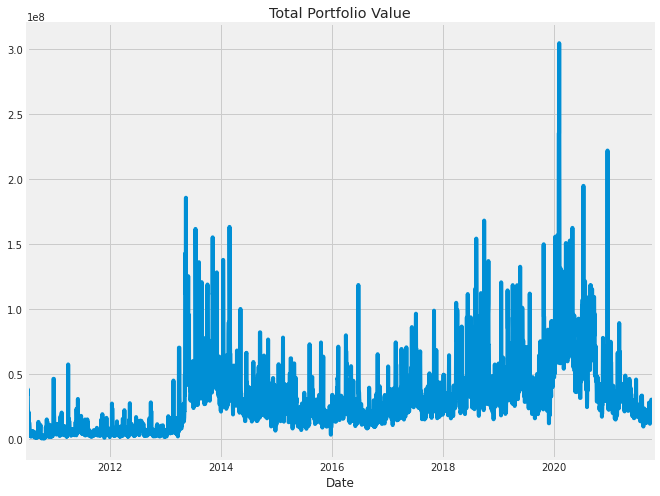

In [15]:
df['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

In [16]:
df['Daily Return'] = df['Total Pos'].pct_change(1)

In [17]:
df['Daily Return'].mean()

0.07803745446697083

<AxesSubplot:ylabel='Density'>

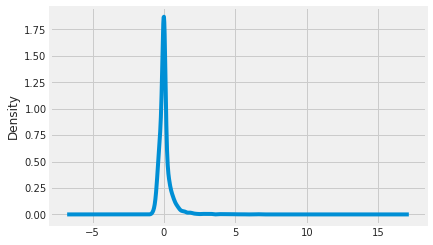

In [18]:
df['Daily Return'].plot(kind='kde')

In [19]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()

<AxesSubplot:xlabel='Date'>

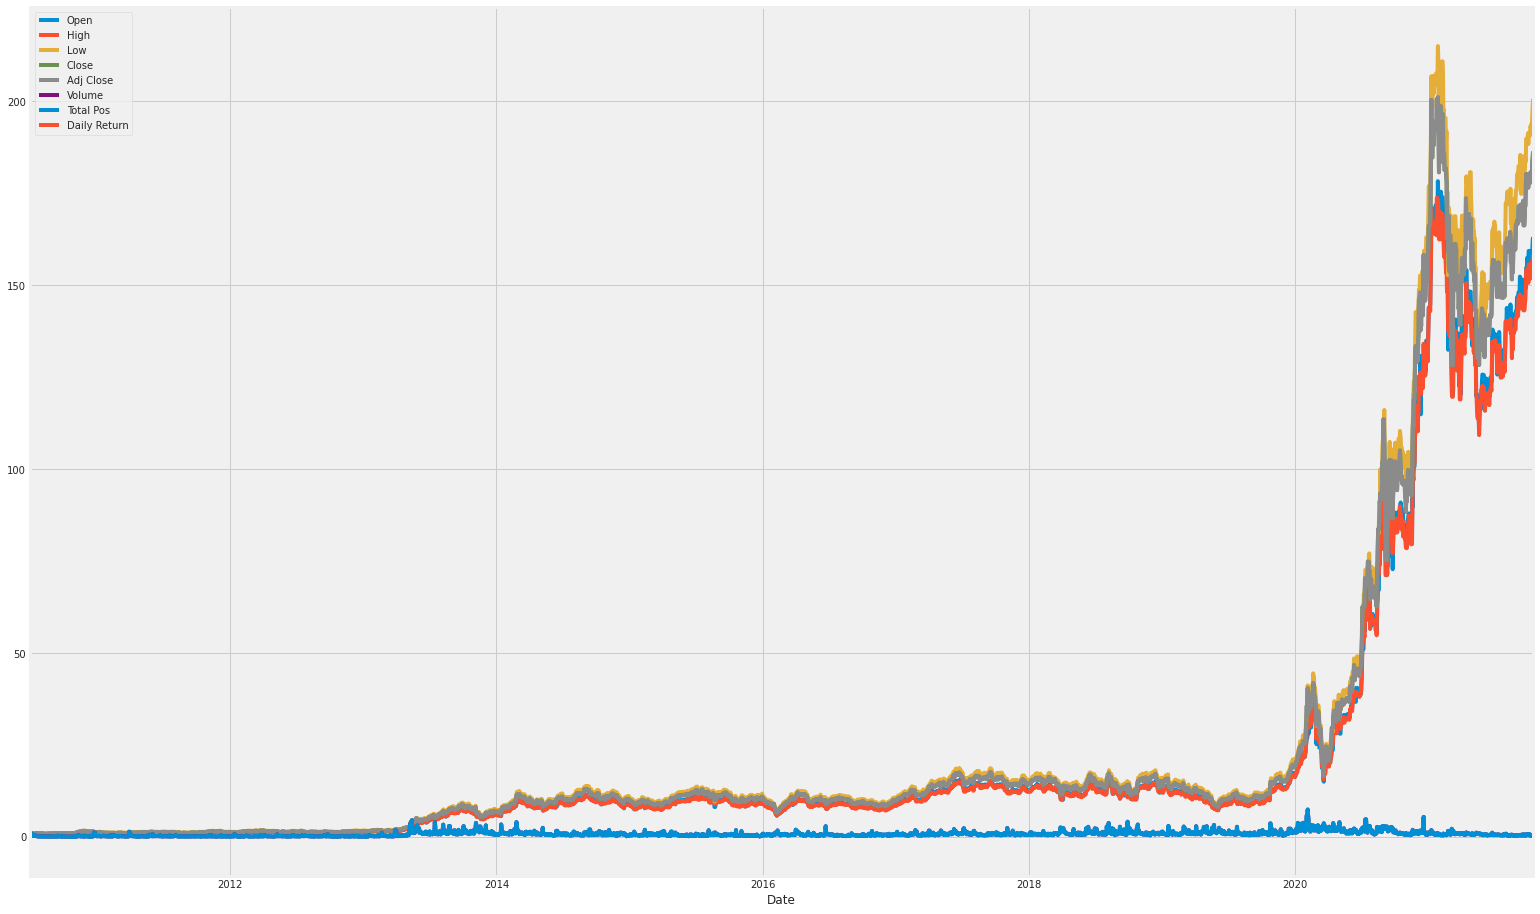

In [20]:
all_plot = df/df.iloc[0]
all_plot.plot(figsize=(24,16))

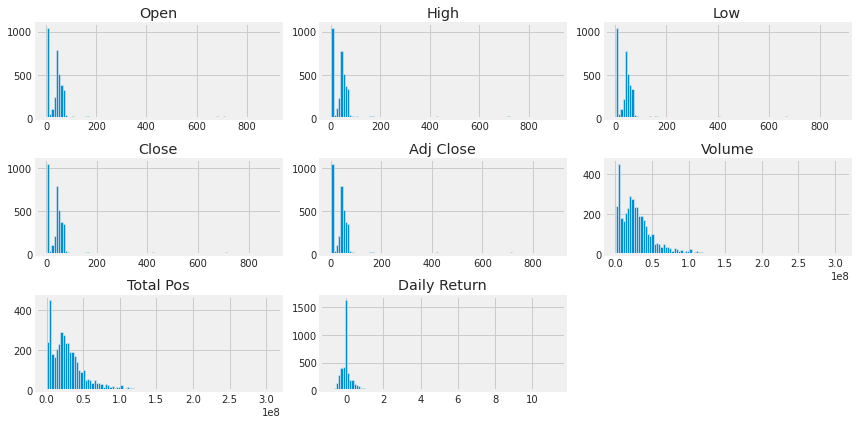

In [21]:
df.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [22]:
df.resample(rule='A').mean()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return
Date,,,,,,,,
2010-12-31,4.697587,4.812783,4.542489,4.664413,4.664413,7.078524e+06,7.078548e+06,0.139712
2011-12-31,5.366948,5.471381,5.241474,5.358427,5.358427,6.326441e+06,6.326468e+06,0.126992
2012-12-31,6.237098,6.364060,6.105792,6.236732,6.236732,6.190474e+06,6.190505e+06,0.095222
2013-12-31,20.858904,21.368137,20.341162,20.880926,20.880926,4.193853e+07,4.193864e+07,0.109582
2014-12-31,44.574356,45.416860,43.690170,44.561726,44.561726,3.484078e+07,3.484100e+07,0.073019
2015-12-31,45.924663,46.676197,45.201907,45.988477,45.988477,2.199258e+07,2.199281e+07,0.081212
2016-12-31,42.023082,42.728803,41.292175,41.989443,41.989443,2.293552e+07,2.293573e+07,0.060155
2017-12-31,62.740044,63.597622,61.782636,62.754148,62.754148,3.187125e+07,3.187156e+07,0.053170
2018-12-31,63.372302,64.691501,62.028970,63.405392,63.405392,4.302389e+07,4.302420e+07,0.065614


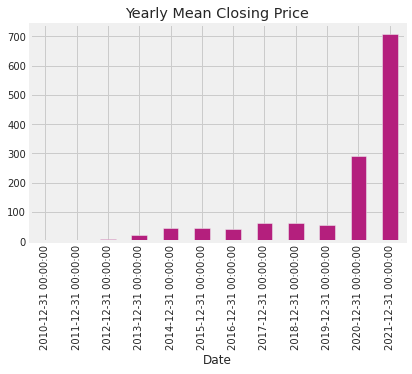

In [23]:
title = 'Yearly Mean Closing Price'
df['Close'].resample('A').mean().plot.bar(title=title,color=['#b41f7d']);

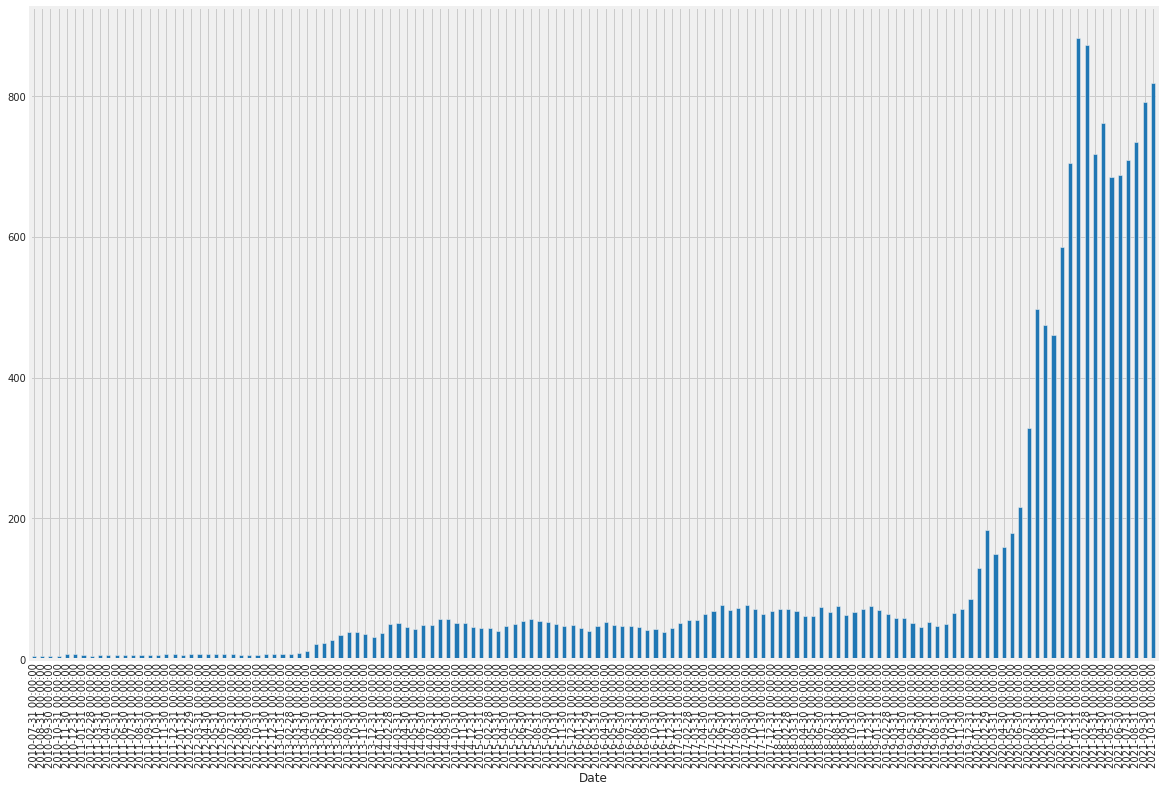

In [24]:
df['Close'].resample('M').max().plot.bar(figsize=(18,12),color='#1f77b4');

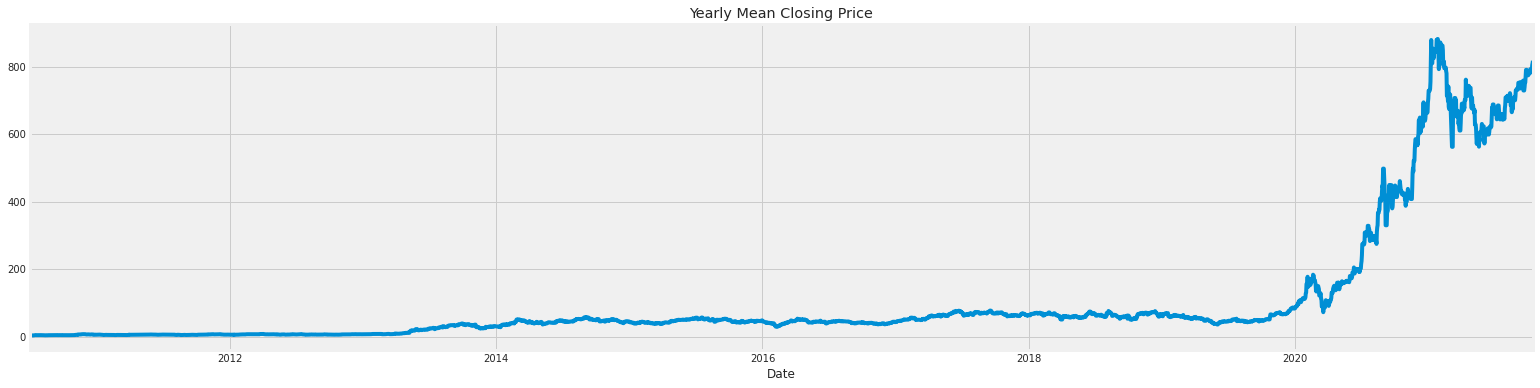

In [25]:
ax = df['Close'].plot(figsize=(24,6),title=title)


In [26]:
df['6-month-SMA'] = df['Close'].rolling(window=6).mean()
df['12-month-SMA'] = df['Close'].rolling(window=12).mean()
df['2-month-SMA'] = df['Close'].rolling(window=2).mean()

In [27]:
df.head(15)

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA
Date,,,,,,,,,,,
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,4.109402e+07,NaN,NaN,NaN,NaN
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,2.569902e+07,-0.374629,NaN,NaN,4.116
2010-07-03,4.000,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.336024,NaN,NaN,3.531
2010-07-04,4.000,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222
2010-07-05,4.000,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,3.520000,NaN,3.222
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,3.460852e+07,0.007980,3.314667,NaN,3.191
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000.0,3.855702e+07,0.114090,3.256667,NaN,3.326
2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000.0,2.025302e+07,-0.474726,3.299667,NaN,3.486


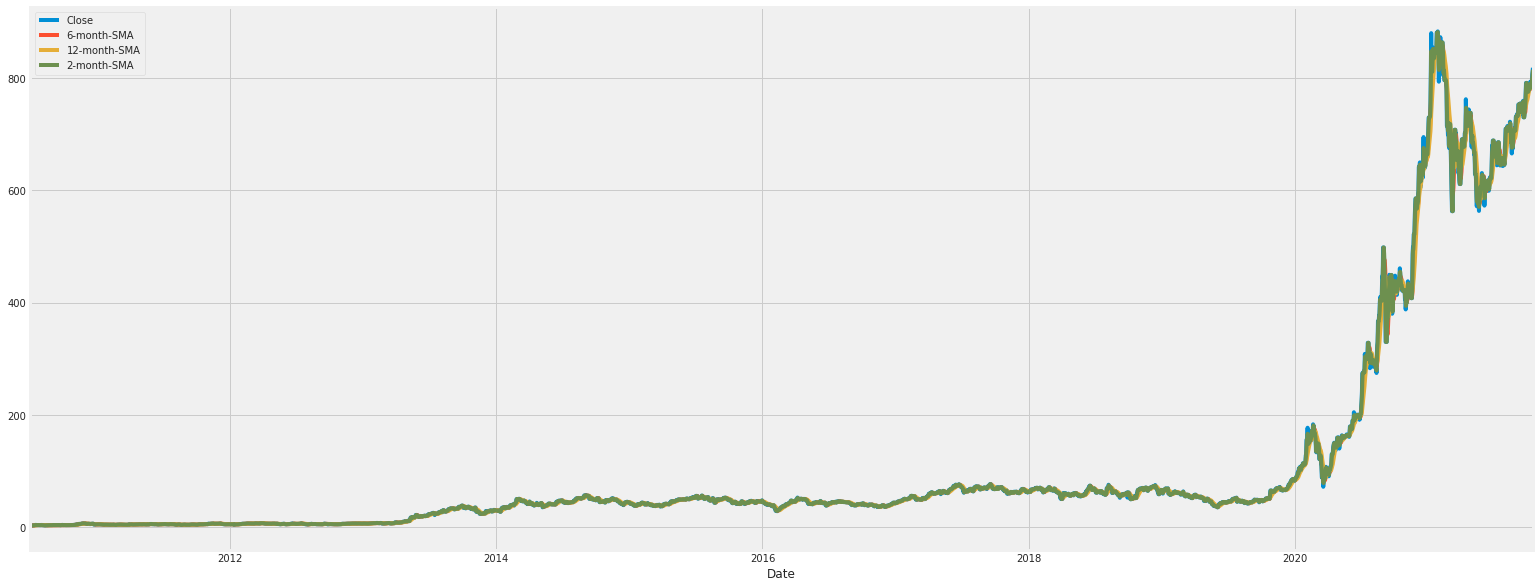

In [28]:
df[["Close","6-month-SMA","12-month-SMA","2-month-SMA"]].plot(figsize=(24,10));

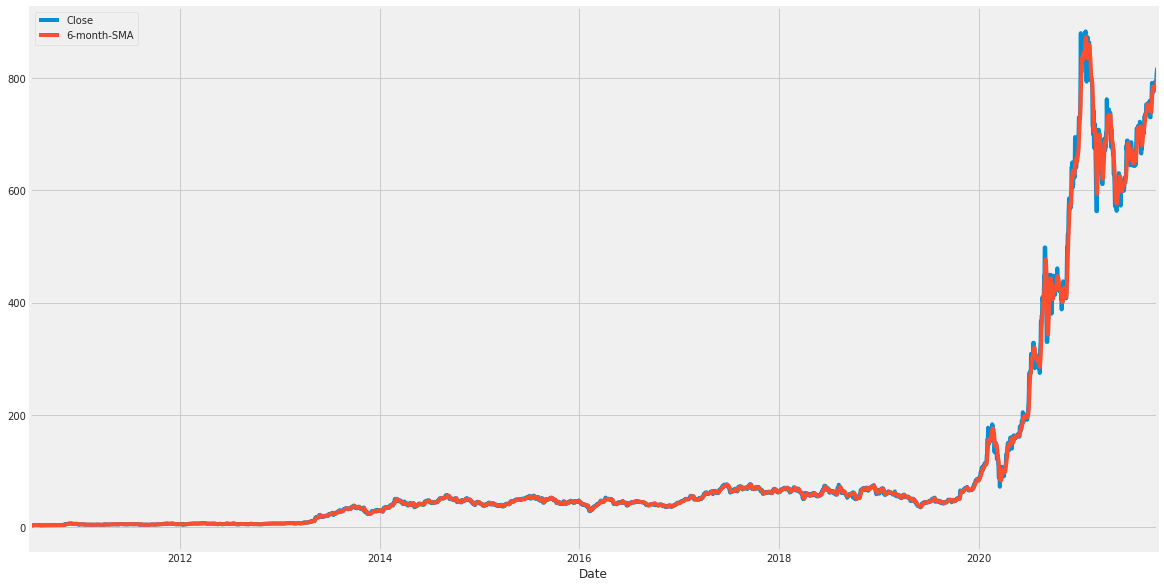

In [29]:
df[["Close","6-month-SMA"]].plot(figsize=(18,10));

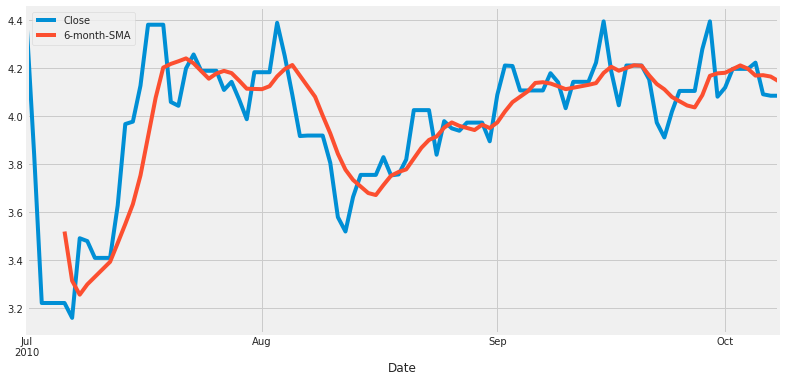

In [30]:
df[['Close','6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [31]:
df['EWMA12'] = df['Close'].ewm(span=14,adjust=True).mean()

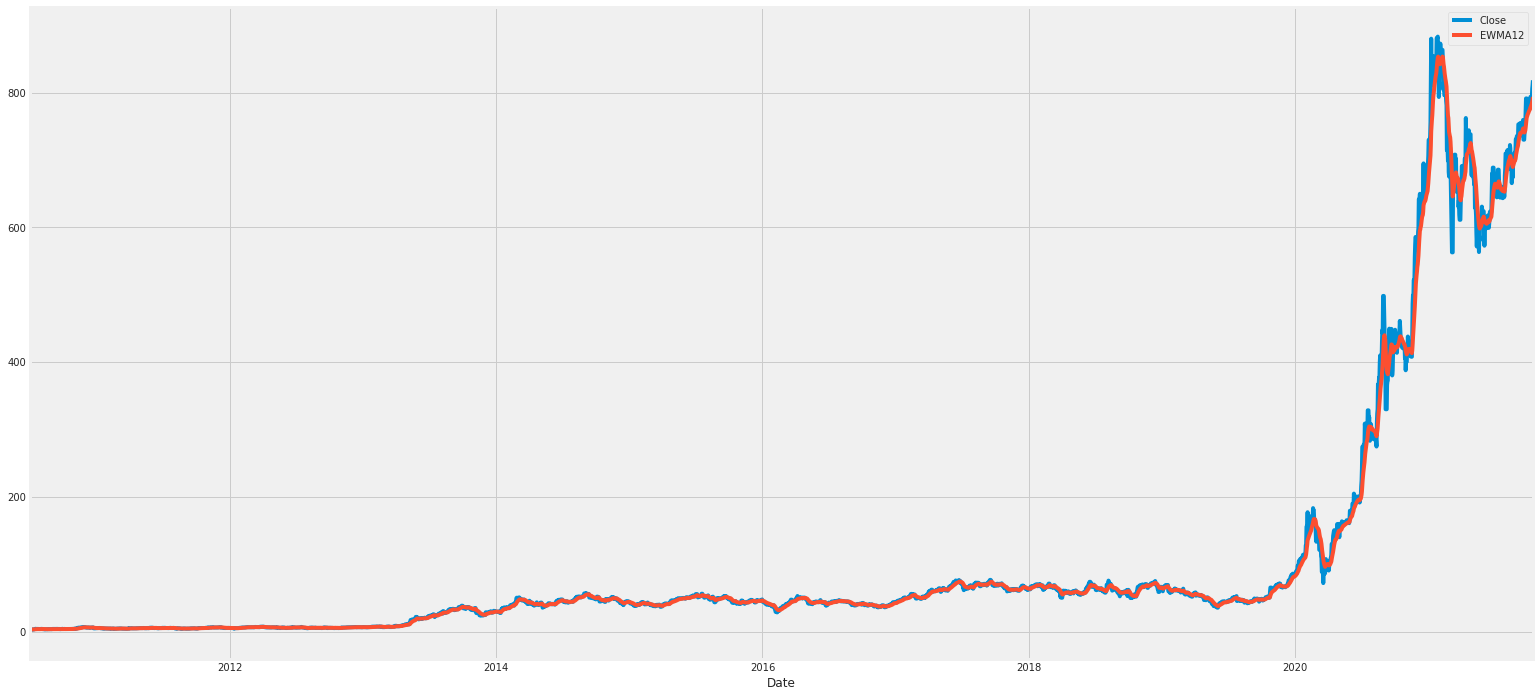

In [32]:
df[['Close','EWMA12']].plot(figsize=(24,12));

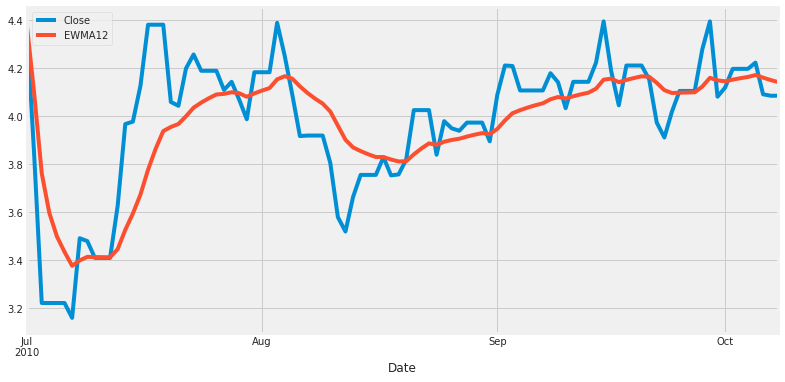

In [33]:
df[['Close','EWMA12']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

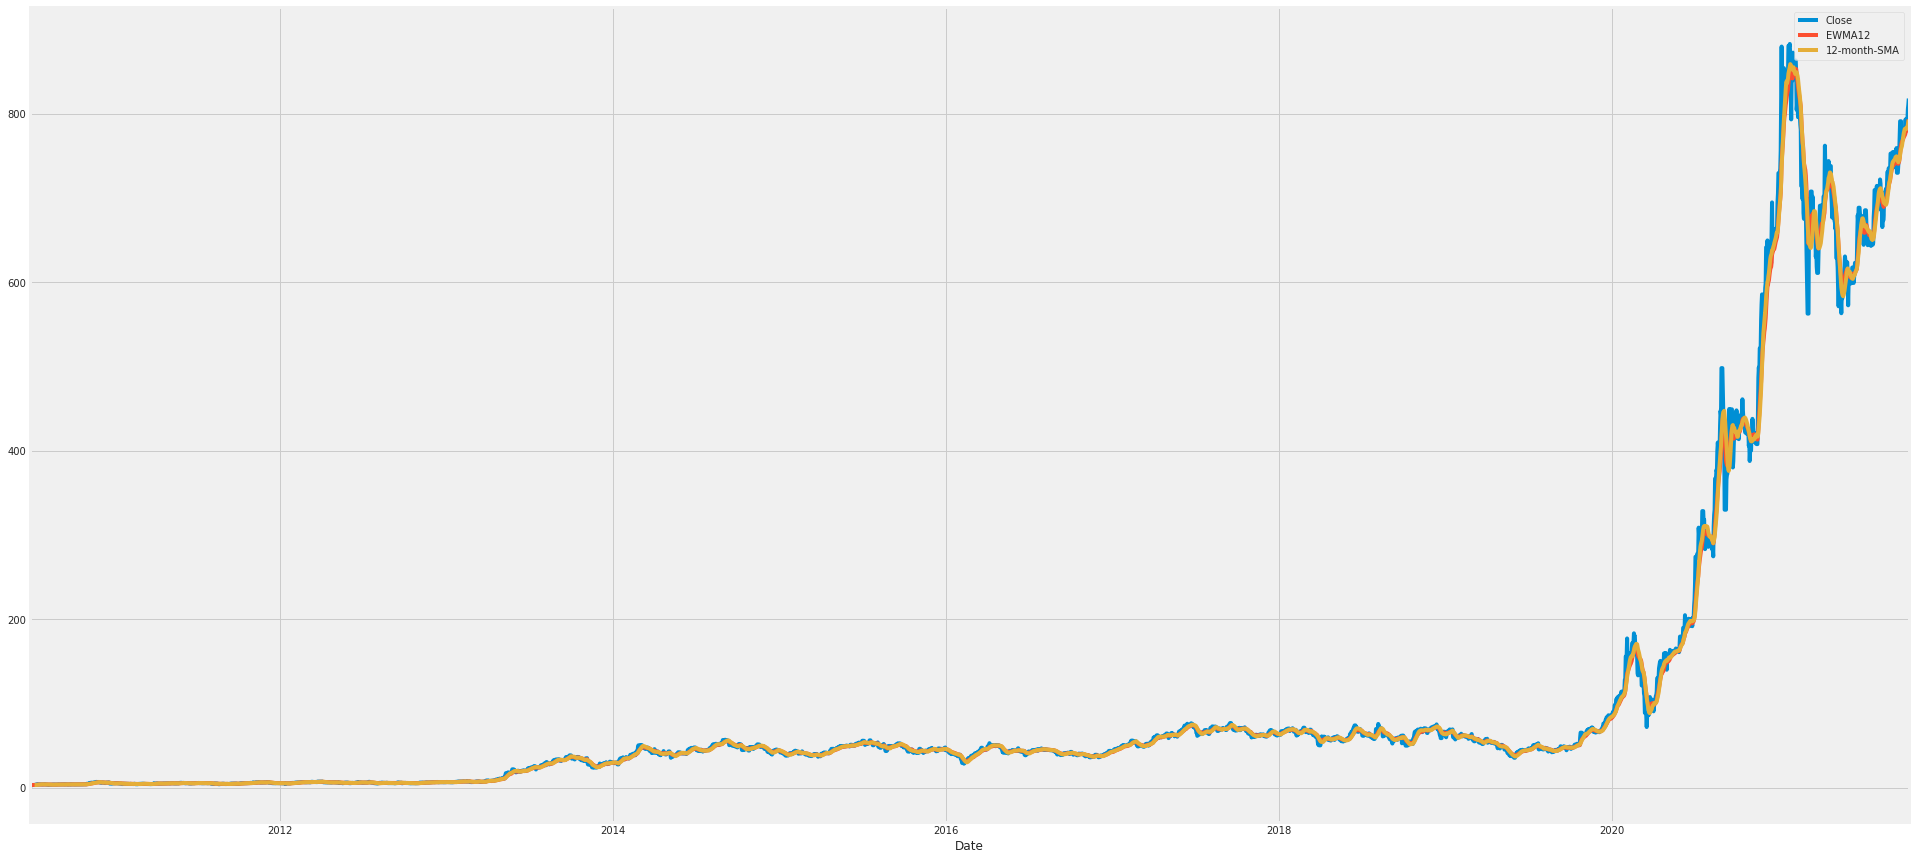

In [34]:
df[['Close','EWMA12','12-month-SMA']].plot(figsize=(30,15)).autoscale(axis='x',tight=True);

In [35]:
span = 12
alpha = 2/(span+1)

In [36]:
df['EWMA12'] = df['Close'].ewm(alpha=alpha,adjust=False).mean()


In [37]:
df['EWMA12'] = df['Close'].ewm(alpha=alpha,adjust=False).mean()


In [38]:
model=SimpleExpSmoothing(df["Close"])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [39]:
model.fit(smoothing_level=alpha,optimized=False)

In [40]:
fitted_model=model.fit(smoothing_level=alpha,optimized=False)

In [41]:
fitted_model.fittedvalues

Date
2010-07-01      4.392000
2010-07-02      4.392000
2010-07-03      4.307077
2010-07-04      4.140142
2010-07-05      3.998889
                 ...    
2021-10-10    782.315583
2021-10-11    783.796263
2021-10-12    785.049146
2021-10-13    788.229273
2021-10-14    791.744772
Freq: D, Length: 4124, dtype: float64

In [42]:
fitted_model.fittedvalues.shift(-1)

Date
2010-07-01      4.392000
2010-07-02      4.307077
2010-07-03      4.140142
2010-07-04      3.998889
2010-07-05      3.879368
                 ...    
2021-10-10    783.796263
2021-10-11    785.049146
2021-10-12    788.229273
2021-10-13    791.744772
2021-10-14           NaN
Freq: D, Length: 4124, dtype: float64

In [43]:
df["SES12"]=fitted_model.fittedvalues.shift(-1)

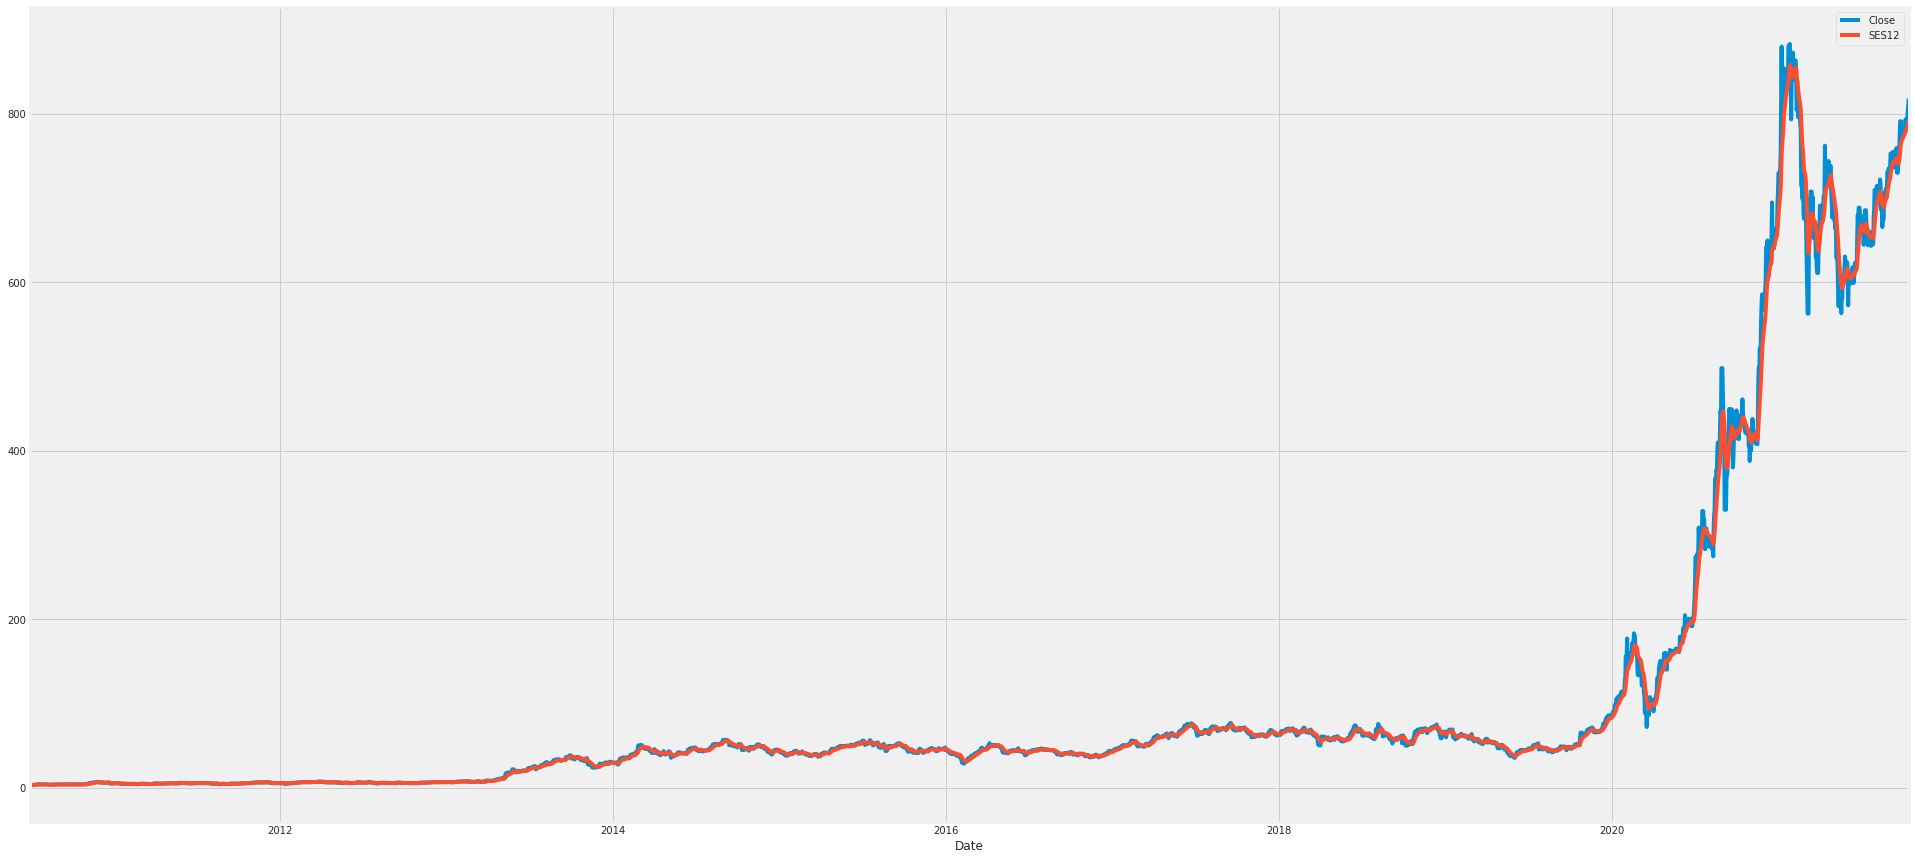

In [44]:
df[['Close',"SES12"]].plot(figsize=(30,15)).autoscale(axis='x',tight=True);

In [45]:
df['DESadd12'] = ExponentialSmoothing(df['Close'], trend='add').fit().fittedvalues.shift(-1)
df.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12
Date,,,,,,,,,,,,,,
2010-07-01,5.0,5.184,4.054,4.392,4.392,41094000.0,4.109402e+07,NaN,NaN,NaN,NaN,4.392000,4.392000,3.823313
2010-07-02,4.6,4.620,3.742,3.840,3.840,25699000.0,2.569902e+07,-0.374629,NaN,NaN,4.116,4.307077,4.307077,3.299592
2010-07-03,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.336024,NaN,NaN,3.531,4.140142,4.140142,2.684807
2010-07-04,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.998889,3.998889,2.664522
2010-07-05,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.879368,3.879368,2.675680


<AxesSubplot:xlabel='Date'>

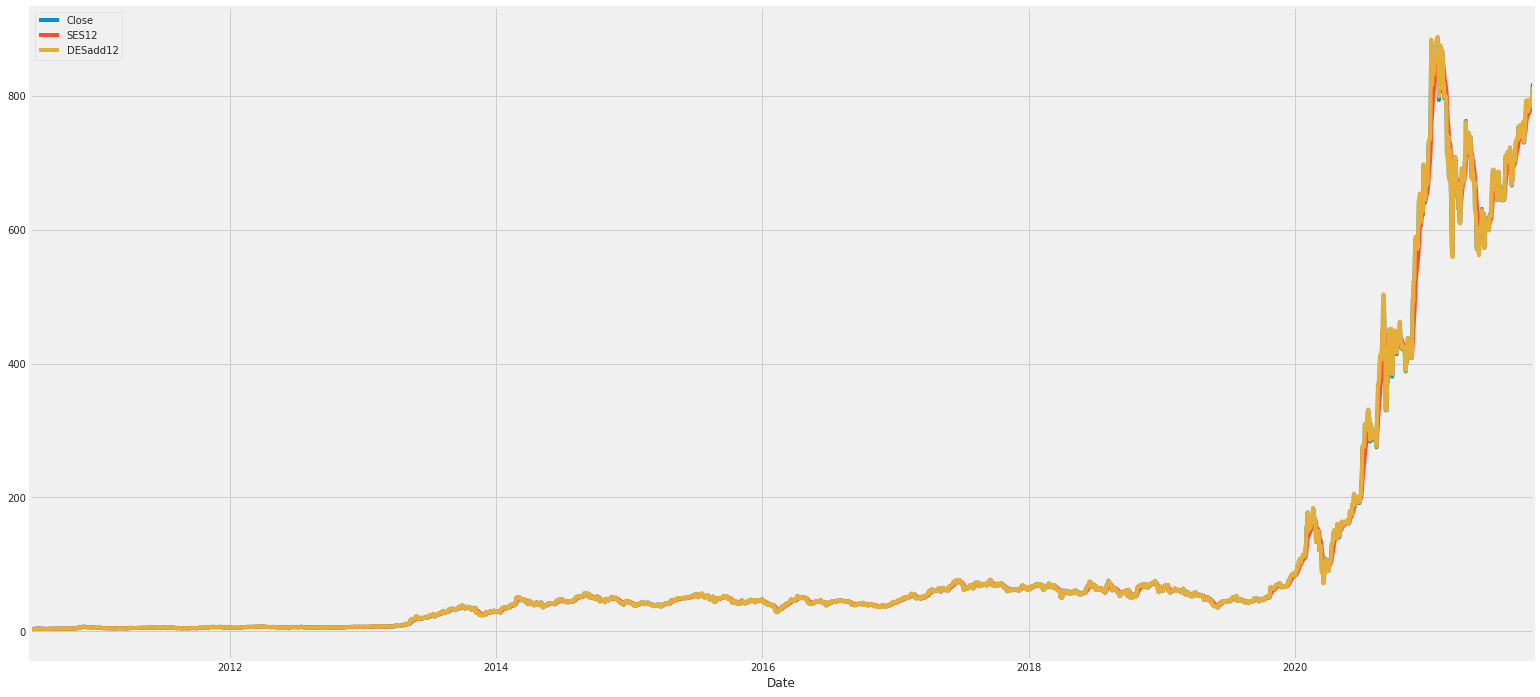

In [46]:
df[['Close',  'SES12', 'DESadd12']].plot(figsize=(24,12))

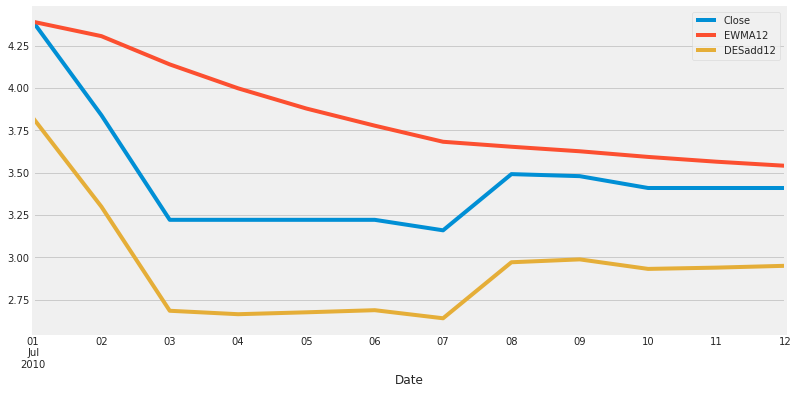

In [47]:
df[['Close','EWMA12','DESadd12']].iloc[:12].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [48]:
df['DESmul12'] = ExponentialSmoothing(df['Close'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Date,,,,,,,,,,,,,,,
2010-07-01,5.0,5.184,4.054,4.392,4.392,41094000.0,4.109402e+07,NaN,NaN,NaN,NaN,4.392000,4.392000,3.823313,5.263021
2010-07-02,4.6,4.620,3.742,3.840,3.840,25699000.0,2.569902e+07,-0.374629,NaN,NaN,4.116,4.307077,4.307077,3.299592,4.489242
2010-07-03,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.336024,NaN,NaN,3.531,4.140142,4.140142,2.684807,3.764716
2010-07-04,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.998889,3.998889,2.664522,3.733662
2010-07-05,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.879368,3.879368,2.675680,3.730069


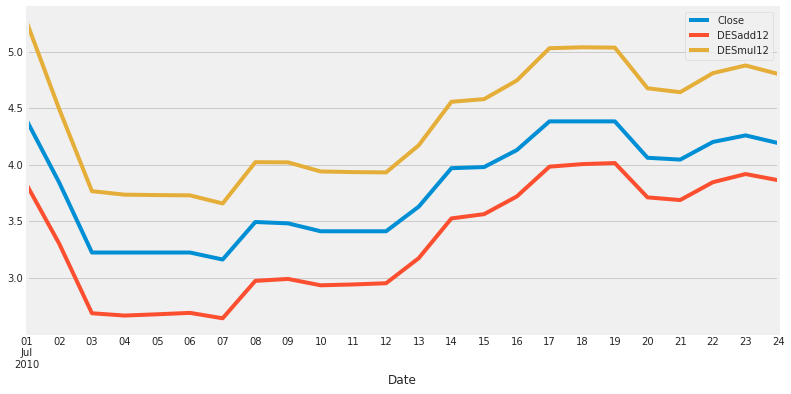

In [49]:
df[['Close','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [50]:
df['TESadd12'] = ExponentialSmoothing(df['Close'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Date,,,,,,,,,,,,,,,,
2010-07-01,5.0,5.184,4.054,4.392,4.392,41094000.0,4.109402e+07,NaN,NaN,NaN,NaN,4.392000,4.392000,3.823313,5.263021,2.975325
2010-07-02,4.6,4.620,3.742,3.840,3.840,25699000.0,2.569902e+07,-0.374629,NaN,NaN,4.116,4.307077,4.307077,3.299592,4.489242,4.787944
2010-07-03,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.336024,NaN,NaN,3.531,4.140142,4.140142,2.684807,3.764716,4.386751
2010-07-04,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.998889,3.998889,2.664522,3.733662,3.369007
2010-07-05,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.879368,3.879368,2.675680,3.730069,2.904509


In [51]:
df['TESmul12'] = ExponentialSmoothing(df['Close'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Date,,,,,,,,,,,,,,,,,
2010-07-01,5.0,5.184,4.054,4.392,4.392,41094000.0,4.109402e+07,NaN,NaN,NaN,NaN,4.392000,4.392000,3.823313,5.263021,2.975325,NaN
2010-07-02,4.6,4.620,3.742,3.840,3.840,25699000.0,2.569902e+07,-0.374629,NaN,NaN,4.116,4.307077,4.307077,3.299592,4.489242,4.787944,NaN
2010-07-03,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.336024,NaN,NaN,3.531,4.140142,4.140142,2.684807,3.764716,4.386751,NaN
2010-07-04,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.998889,3.998889,2.664522,3.733662,3.369007,NaN
2010-07-05,4.0,4.000,3.166,3.222,3.222,34334500.0,3.433452e+07,0.000000,NaN,NaN,3.222,3.879368,3.879368,2.675680,3.730069,2.904509,NaN


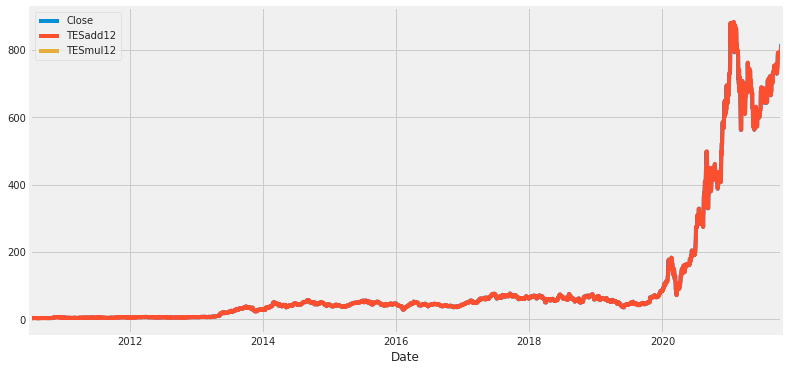

In [52]:
df[['Close','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

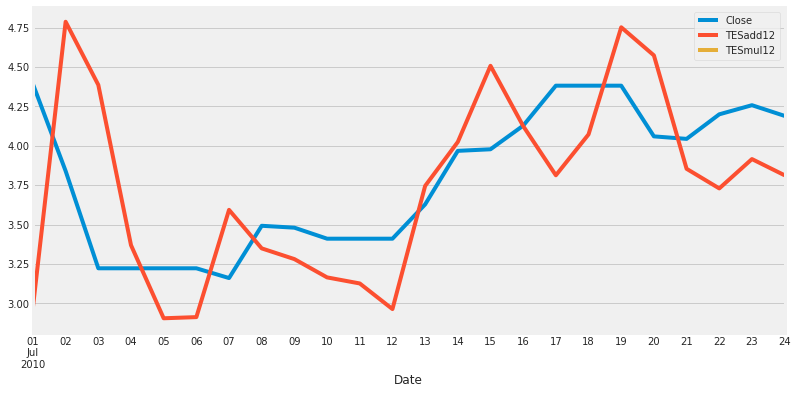

In [53]:
df[['Close','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


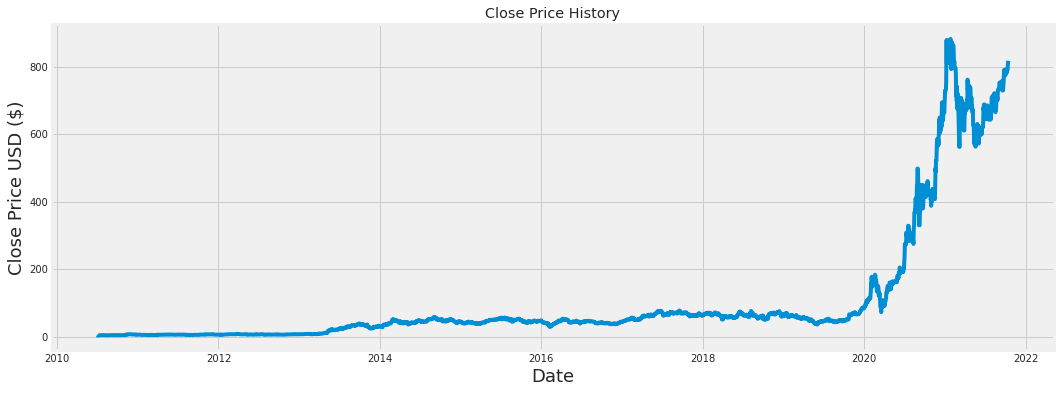

In [54]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [55]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

3918

In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[1.40011133e-03],
       [7.72788721e-04],
       [7.04601481e-05],
       ...,
       [9.12072490e-01],
       [9.18163936e-01],
       [9.26391852e-01]])

In [57]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([1.40011133e-03, 7.72788721e-04, 7.04601481e-05, 7.04601481e-05,
       7.04601481e-05, 7.04601481e-05, 0.00000000e+00, 3.77302728e-04,
       3.63665280e-04, 2.84113500e-04, 2.84113500e-04, 2.84113500e-04,
       5.31860473e-04, 9.18254833e-04, 9.29619373e-04, 1.10008747e-03,
       1.38874679e-03, 1.38874679e-03, 1.38874679e-03, 1.02280860e-03,
       1.00462534e-03, 1.18191216e-03, 1.24782649e-03, 1.17054762e-03,
       1.17054762e-03, 1.17054762e-03, 1.07963130e-03, 1.11827074e-03,
       1.03417314e-03, 9.40983913e-04, 1.16372890e-03, 1.16372890e-03,
       1.16372890e-03, 1.39783842e-03, 1.24100777e-03, 1.05690222e-03,
       8.61432133e-04, 8.63705041e-04, 8.63705041e-04, 8.63705041e-04,
       7.34149285e-04, 4.77310681e-04, 4.09123440e-04, 5.72772817e-04,
       6.77326585e-04, 6.77326585e-04, 6.77326585e-04, 7.61424181e-04,
       6.75053677e-04, 6.79599493e-04, 7.50059641e-04, 9.84169165e-04,
       9.84169165e-04, 9.84169165e-04, 7.72788721e-04, 9.31892281e-04,
     

In [58]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [59]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [60]:
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]  

In [61]:
history =model.fit(x_train, y_train, 
                        epochs=10,
                        batch_size=1,
                        callbacks=callbacks,
                        )

2022-06-09 00:20:38.593016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3858/3858 [==============================] - 210s 54ms/step - loss: 0.0026
Epoch 2/10
3858/3858 [==============================] - 206s 53ms/step - loss: 5.4315e-04
Epoch 3/10
3858/3858 [==============================] - 218s 56ms/step - loss: 4.9568e-04
Epoch 4/10
3858/3858 [==============================] - 209s 54ms/step - loss: 3.4525e-04
Epoch 5/10
3858/3858 [==============================] - 208s 54ms/step - loss: 2.1644e-04
Epoch 6/10
3858/3858 [==============================] - 209s 54ms/step - loss: 2.5749e-04
Epoch 7/10
3858/3858 [==============================] - 204s 53ms/step - loss: 1.8276e-04
Epoch 8/10
3858/3858 [==============================] - 205s 53ms/step - loss: 1.9895e-04
Epoch 9/10
3858/3858 [==============================] - 205s 53ms/step - loss: 1.6363e-04
Epoch 10/10
3858/3858 [==============================] - 210s 54ms/step - loss: 1.5909e-04


In [62]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

41.890368968534546

In [63]:
mean_absolute_error(y_test, predictions)


39.616469934447046

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


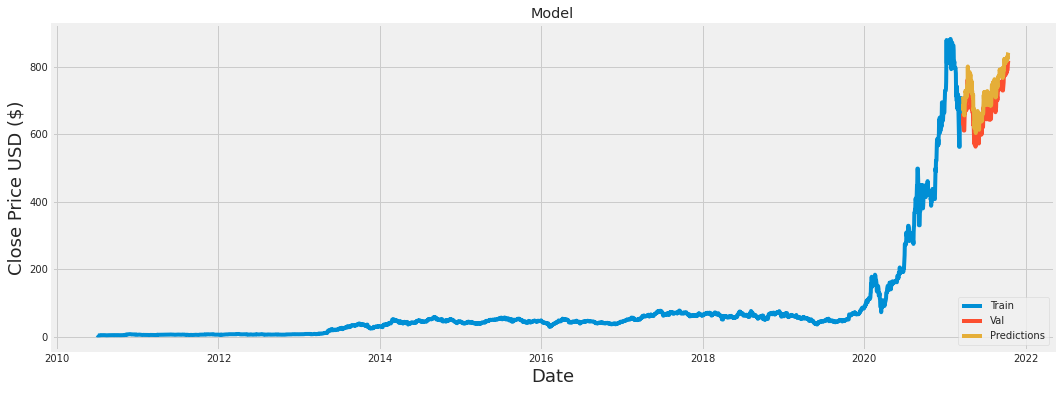

In [64]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [65]:
predictions = model.predict(x_test)


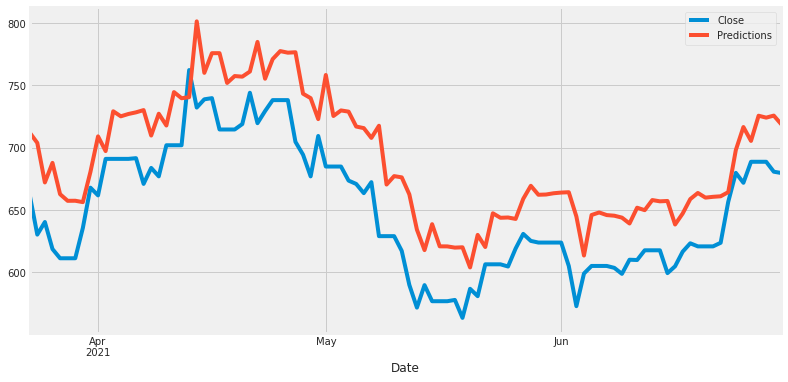

In [66]:
valid[['Close','Predictions']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [67]:
valid

,Close,Predictions
Date,,
2021-03-23,662.159973,712.147583
2021-03-24,630.270020,703.861816
2021-03-25,640.390015,672.133606
2021-03-26,618.710022,687.842041
2021-03-27,611.289978,662.710388
...,...,...
2021-10-10,791.940002,828.202332
2021-10-11,791.940002,826.535034
2021-10-12,805.719971,827.102478
